In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# List files in a specific folder where the shortcut was added
folder_path = '/content/drive/My Drive/DLNN_Project/'
files = os.listdir(folder_path)
print(files)

['deeplearning_malignant']


In [3]:
import pandas as pd

# Path to the directory containing your dataset
data_dir = '/content/drive/MyDrive/DLNN_Project/deeplearning_malignant/'

# Read training and testing CSV files
train_df = pd.read_csv(data_dir + 'Train.csv')
test_df = pd.read_csv(data_dir + 'Test_GroundTruth.csv')

# Display the first few rows of the dataframes
print(train_df.head())
print(test_df.head())

# Define the label mapping for the test dataset
label_mapping2 = {
    "nv": 0,
    "bkl": 0,
    "df": 0,
    "mel": 1,
    "vasc": 0,
    "bcc": 0,
    "akiec": 0
}

# Map the 'dx' column using the label mapping and create the target column for the test dataset
test_df['mapped_dx'] = test_df['dx'].map(label_mapping2)
test_df['target'] = test_df['mapped_dx']  # Creating the target column

# Display the first few rows of the updated test dataset
print(test_df.head())

     image_name  patient_id   lesion_id     sex  age_approx  \
0  ISIC_2637011  IP_7279968  IL_7972535    male        45.0   
1  ISIC_0015719  IP_3075186  IL_4649854  female        45.0   
2  ISIC_0052212  IP_2842074  IL_9087444  female        50.0   
3  ISIC_0068279  IP_6890425  IL_4255399  female        45.0   
4  ISIC_0074268  IP_8723313  IL_6898037  female        55.0   

  anatom_site_general_challenge diagnosis benign_malignant  target  
0                     head/neck   unknown           benign       0  
1               upper extremity   unknown           benign       0  
2               lower extremity     nevus           benign       0  
3                     head/neck   unknown           benign       0  
4               upper extremity   unknown           benign       0  
         lesion_id      image_id   dx    dx_type   age     sex localization  \
0  HAMTEST_0000000  ISIC_0034524   nv  follow_up  40.0  female         back   
1  HAMTEST_0000001  ISIC_0034525   nv      histo 

In [4]:
import os
from sklearn.model_selection import train_test_split

# Define image directories
train_image_dir = '/content/drive/MyDrive/DLNN_Project/deeplearning_malignant/Train_images/'
test_image_dir = '/content/drive/MyDrive/DLNN_Project/deeplearning_malignant/Test_Images_1/'

# Add image path columns
train_df['image_path'] = train_image_dir + train_df['image_name'] + '.jpg'
test_df['image_path'] = test_image_dir + test_df['image_id'] + '.jpg'

# Filter out rows with missing image files
train_df_cleaned = train_df[train_df['image_path'].apply(os.path.exists)]
test_df_cleaned = test_df[test_df['image_path'].apply(os.path.exists)]

# Split the cleaned training data into training and validation sets
train_data, val_data = train_test_split(train_df_cleaned, test_size=0.2, random_state=123)

# Ensure the test data has the correct structure
if 'mapped_dx' in test_df_cleaned.columns and 'target' not in test_df_cleaned.columns:
    test_df_cleaned = test_df_cleaned.rename(columns={'mapped_dx': 'target'})

# Combine train, validation, and test sets for easy access
combined_data = {
    'train': train_data,
    'val': val_data,
    'test': test_df_cleaned
}

# Display summaries
for split_name, data in combined_data.items():
    print(f"\n{split_name.capitalize()} dataset:")
    print(f"Number of samples: {len(data)}")
    print(data.head())


Train dataset:
Number of samples: 26500
         image_name  patient_id   lesion_id     sex  age_approx  \
31135  ISIC_9408875  IP_7785592  IL_8582128    male        40.0   
14760  ISIC_4521482  IP_2153088  IL_4870875  female        30.0   
27107  ISIC_8209221  IP_6342369  IL_7602831  female        30.0   
27653  ISIC_8369457  IP_8678278  IL_5505871    male        25.0   
28792  ISIC_8707477  IP_3937212  IL_5680467  female        40.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  \
31135               upper extremity   unknown           benign       0   
14760                         torso   unknown           benign       0   
27107                         torso   unknown           benign       0   
27653                  oral/genital   unknown           benign       0   
28792                           NaN   unknown           benign       0   

                                              image_path  
31135  /content/drive/MyDrive/DLNN_Project/deeplearn

In [5]:
import tensorflow as tf

# Parameters
batch_size = 32
img_height = 224
img_width = 224

# Function to load and preprocess an image and its label
def load_image_and_label(image_path, label):
    # Step 1: Read the image file from the given path
    img = tf.io.read_file(image_path)

    # Step 2: Decode the image into a tensor
    img = tf.image.decode_jpeg(img, channels=3)

    # Step 3: Resize the image to the specified dimensions
    img = tf.image.resize(img, [img_height, img_width])

    # Step 4: Normalize the pixel values
    img = img / 255.0

    # Step 5: Return the processed image and its label
    return img, label

# Function to create a dataset
def create_dataset(dataframe, batch_size, is_test=False):
    # If it's test data, labels might be missing (use None)
    labels = dataframe['target'].values if not is_test else [0] * len(dataframe)
    dataset = tf.data.Dataset.from_tensor_slices((dataframe['image_path'].values, labels))
    dataset = dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create training, validation, and test datasets
train_dataset = create_dataset(train_data, batch_size=batch_size)
val_dataset = create_dataset(val_data, batch_size=batch_size)
test_dataset = create_dataset(test_df_cleaned, batch_size=batch_size, is_test=True)

# Example output
print(f"Training dataset batches: {len(train_dataset)}")
print(f"Validation dataset batches: {len(val_dataset)}")
print(f"Test dataset batches: {len(test_dataset)}")

Training dataset batches: 829
Validation dataset batches: 208
Test dataset batches: 48


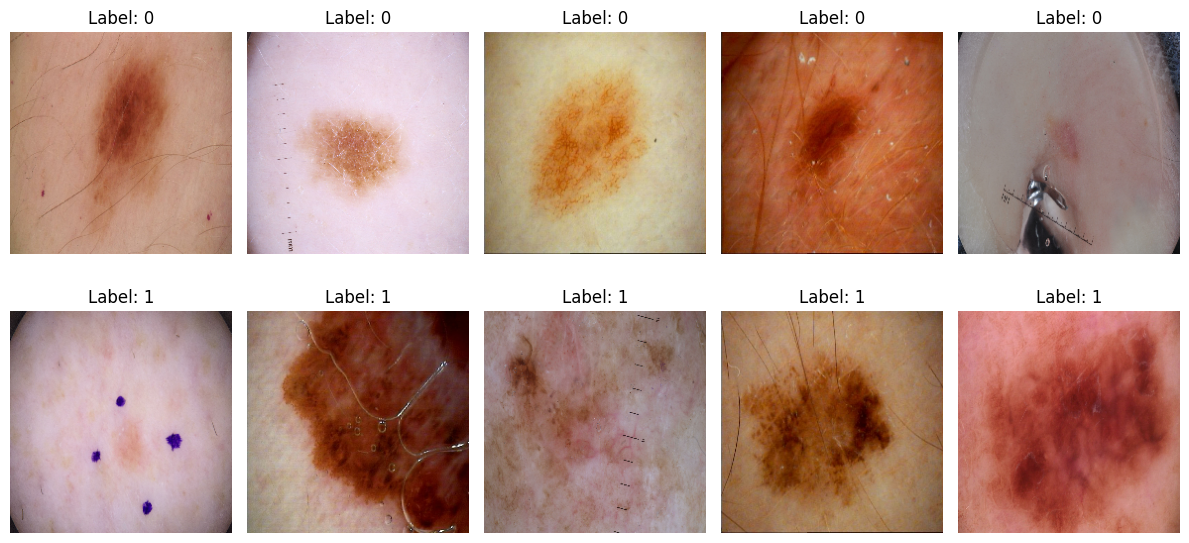

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to sample images from both classes (0 and 1)
def sample_images_by_class(dataset, num_classes=2, samples_per_class=1):
    class_samples = {i: [] for i in range(num_classes)}  # Dictionary to store sampled images by class
    for images, labels in dataset.unbatch():  # Unbatch the dataset to access individual images and labels
        label = int(labels.numpy())  # Convert Tensor label to a scalar integer
        if len(class_samples[label]) < samples_per_class:  # Check if we need more samples for this class
            class_samples[label].append(images.numpy())  # Add the image to the respective class
        # Break the loop if we have collected enough samples for all classes
        if all(len(class_samples[i]) >= samples_per_class for i in range(num_classes)):
            break
    return class_samples

# Sample images from the training dataset
samples = sample_images_by_class(train_dataset, num_classes=2, samples_per_class=5)

# Visualize the sampled images
plt.figure(figsize=(12, 6))
for class_label, images in samples.items():
    for i, img in enumerate(images):
        ax = plt.subplot(2, 5, class_label * 5 + i + 1)
        plt.imshow(img)
        plt.title(f"Label: {class_label}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
AUTOTUNE = tf.data.AUTOTUNE  # Automatically optimize the data pipeline

# Apply caching, shuffling, and prefetching to the training dataset
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Apply caching and prefetching to the validation dataset
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Apply caching and prefetching to the test dataset (no shuffle as it's used for evaluation)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Example of inspecting dataset properties
print("Optimized datasets:")
print(f"Train dataset batches: {len(train_dataset)}")
print(f"Validation dataset batches: {len(val_dataset)}")
print(f"Test dataset batches: {len(test_dataset)}")

Optimized datasets:
Train dataset batches: 829
Validation dataset batches: 208
Test dataset batches: 48


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Define the CNN Model
model = Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

# Evaluate on Test Dataset
test_results = model.evaluate(test_dataset)
print(f"Test Results - Loss: {test_results[0]:.4f}, Accuracy: {test_results[1]:.4f}, Precision: {test_results[2]:.4f}, Recall: {test_results[3]:.4f}")

# Predict on Test Dataset
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.3).astype(int)  # Use a fixed threshold of 0.3

# Extract True Labels
true_labels = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)

# Compute Evaluation Metrics
precision = precision_score(true_labels, predicted_labels, zero_division=0)
recall = recall_score(true_labels, predicted_labels, zero_division=0)
f1 = f1_score(true_labels, predicted_labels, zero_division=0)

print(f"Final Test Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Epoch 1/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 2733s 659ms/step - accuracy: 0.9700 - loss: 0.5613 - precision: 0.0209 - recall: 0.0169 - val_accuracy: 0.9831 - val_loss: 0.1140 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9826 - loss: 0.1089 - precision: 0.8651 - recall: 0.0087 - val_accuracy: 0.9831 - val_loss: 0.1106 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9810 - loss: 0.0986 - precision: 0.1432 - recall: 0.0041 - val_accuracy: 0.9829 - val_loss: 0.0804 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9820 - loss: 0.0847 - precision: 0.5280 - recall: 0.0134 - val_accuracy: 0.9831 - val_loss: 0.0768 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/

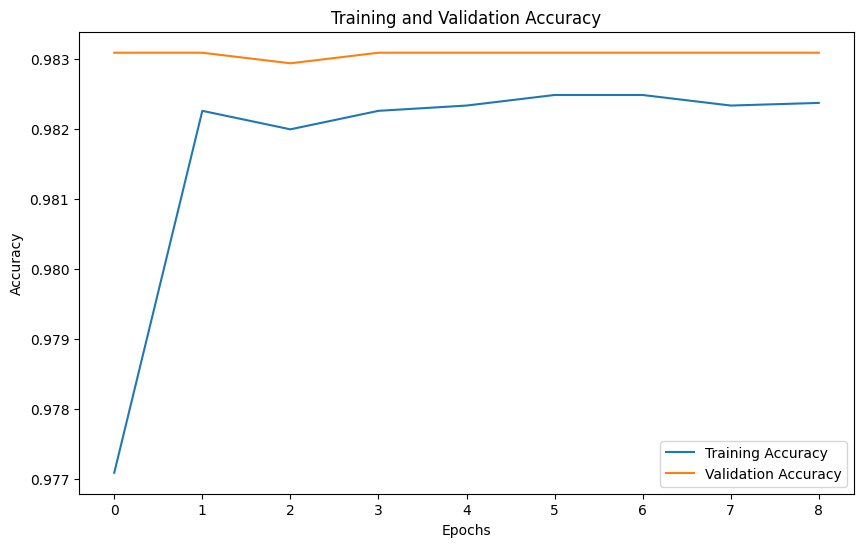

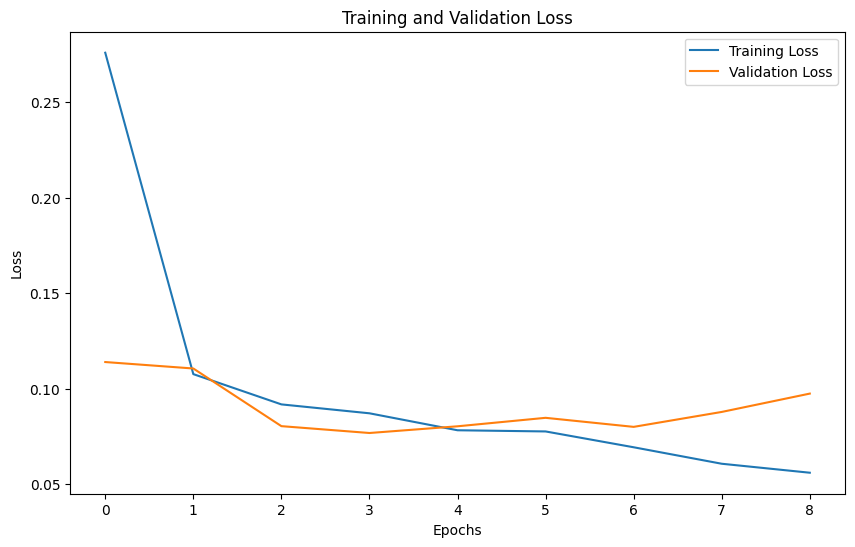

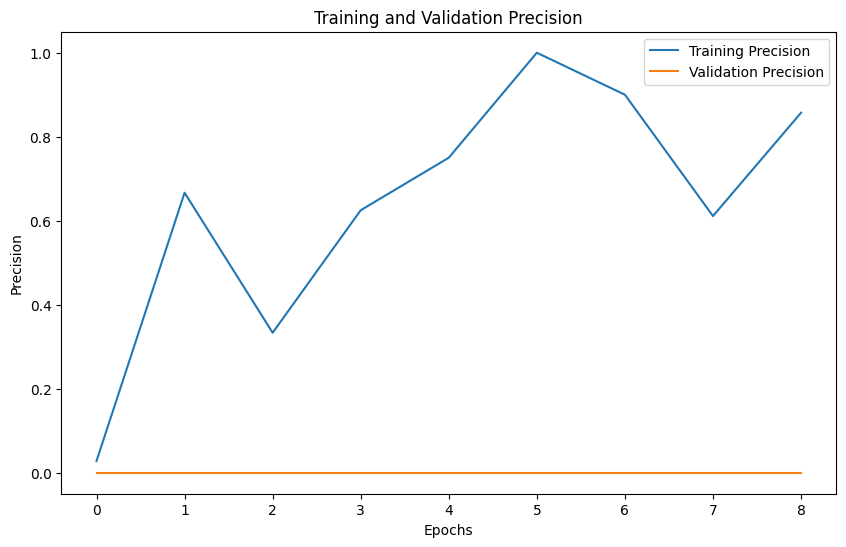

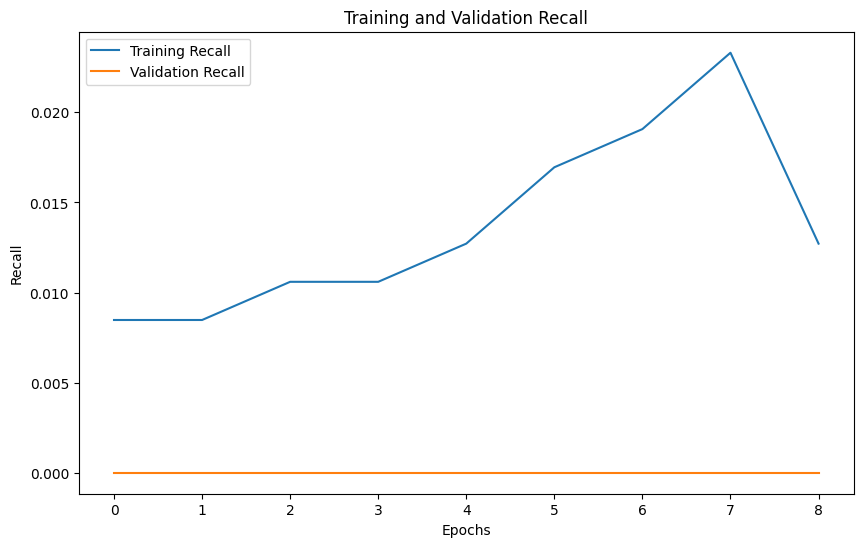

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation precision
if 'precision' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Training and Validation Precision')
    plt.show()

# Plot training and validation recall
if 'recall' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Training and Validation Recall')
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Parameters
img_height, img_width = 224, 224  # Image dimensions
batch_size = 32  # Batch size

# Select Pre-Trained Model (EfficientNet or DenseNet)
base_model = EfficientNetB0(
    input_shape=(img_height, img_width, 3),
    include_top=False,  # Remove the default top classification layer
    weights="imagenet"  # Load pre-trained ImageNet weights
)
# Alternatively, use DenseNet121:
# base_model = DenseNet121(input_shape=(img_height, img_width, 3), include_top=False, weights="imagenet")

# Freeze Base Model
base_model.trainable = False  # Fine-tuning will start with the pre-trained layers frozen

# Add Custom Layers
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)  # Reduce feature map dimensions
x = layers.Dropout(0.5)(x)  # Regularization
outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification
model = Model(inputs, outputs)

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

# Unfreeze and Fine-Tune
base_model.trainable = True  # Unfreeze all layers for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate on Test Dataset
test_results = model.evaluate(test_dataset)
print(f"Test Results - Loss: {test_results[0]:.4f}, Accuracy: {test_results[1]:.4f}, "
      f"Precision: {test_results[2]:.4f}, Recall: {test_results[3]:.4f}")

# Predictions on Test Dataset
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int)  # Threshold at 0.5

# Extract True Labels
true_labels = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)

# Compute Additional Metrics
precision = precision_score(true_labels, predicted_labels, zero_division=0)
recall = recall_score(true_labels, predicted_labels, zero_division=0)
f1 = f1_score(true_labels, predicted_labels, zero_division=0)

print(f"Final Test Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
829/829 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - accuracy: 0.9457 - loss: 0.4522 - precision_1: 0.0241 - recall_1: 0.0471 - val_accuracy: 0.9831 - val_loss: 0.1532 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
829/829 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9826 - loss: 0.1316 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9831 - val_loss: 0.0999 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
829/829 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9821 - loss: 0.0988 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9831 - val_loss: 0.0893 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/20
829/829 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9821 - loss: 0.0926 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9831 - val

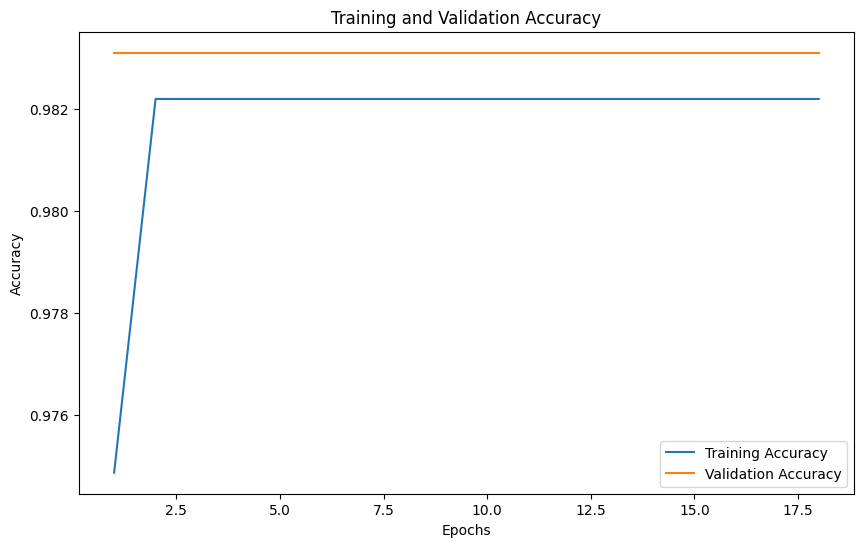

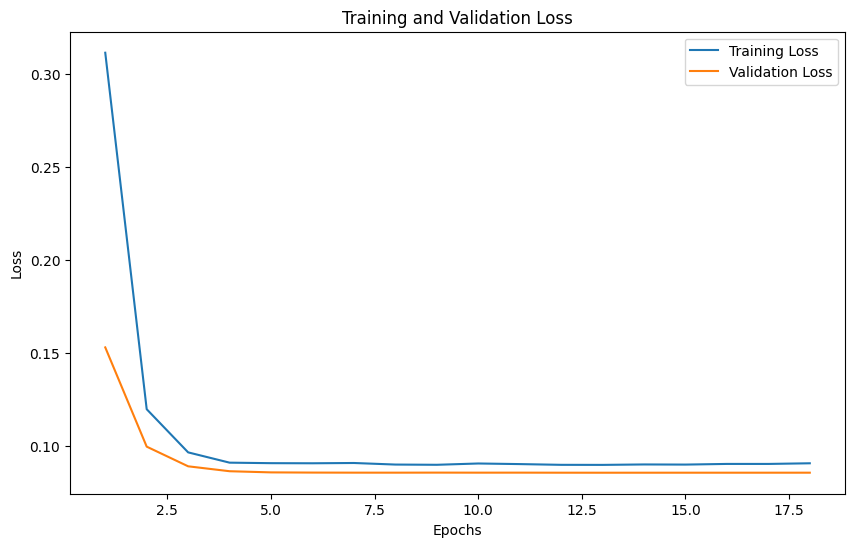

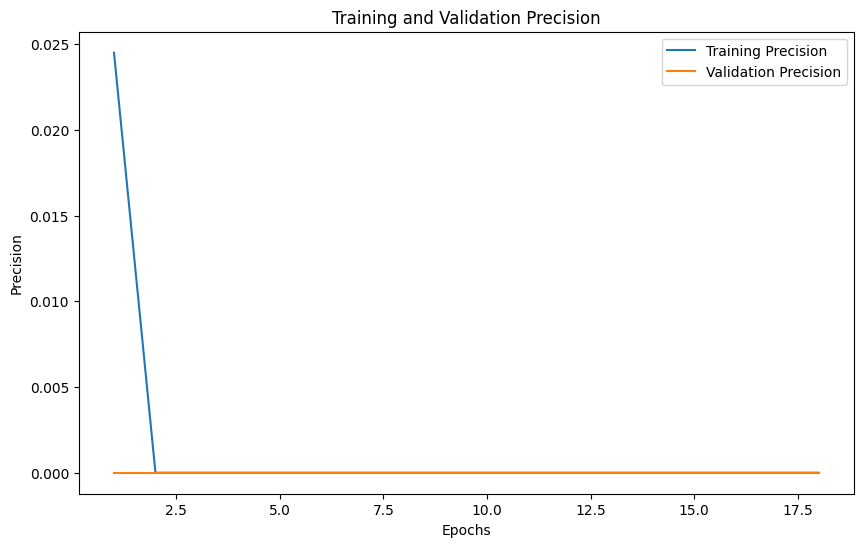

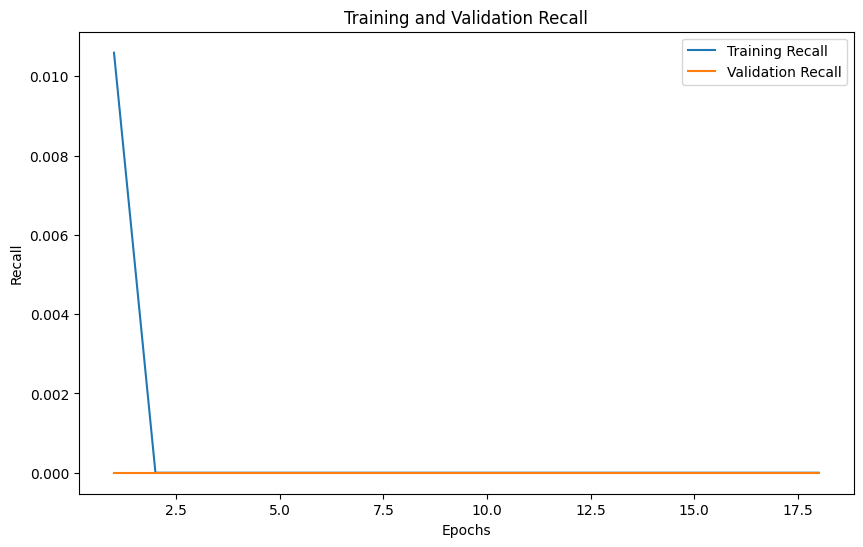

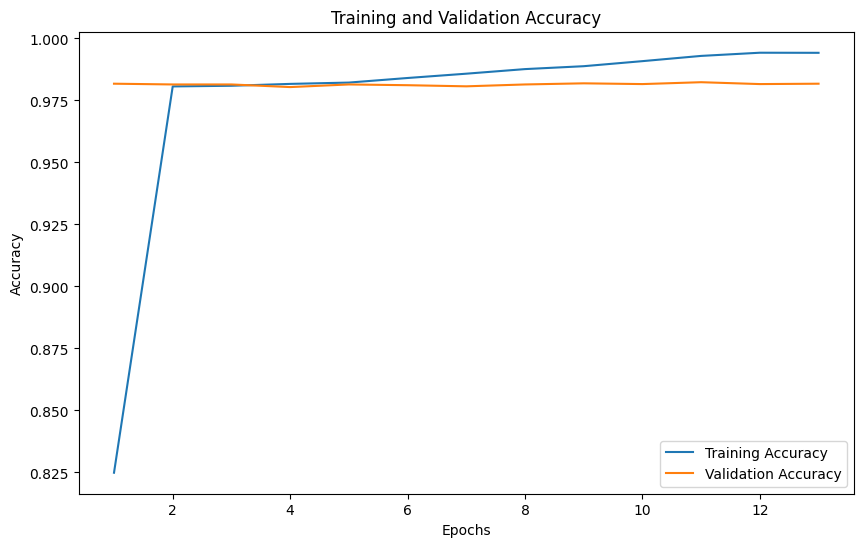

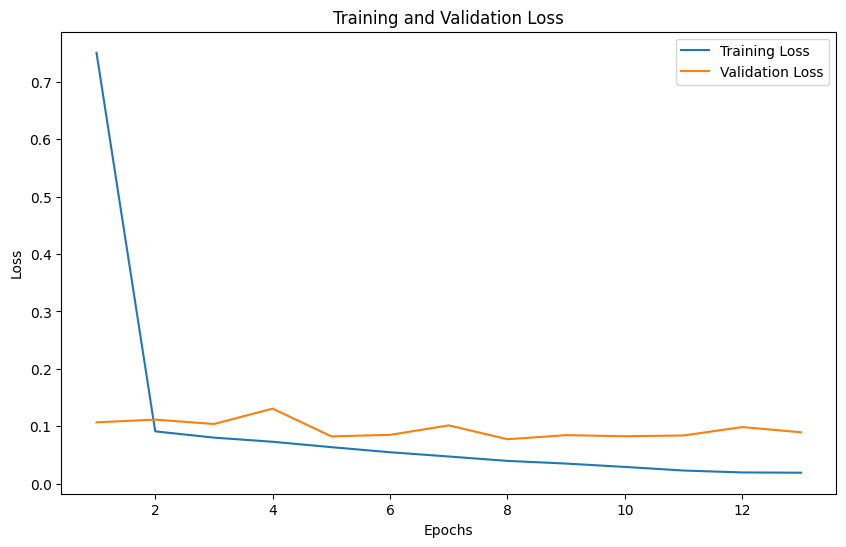

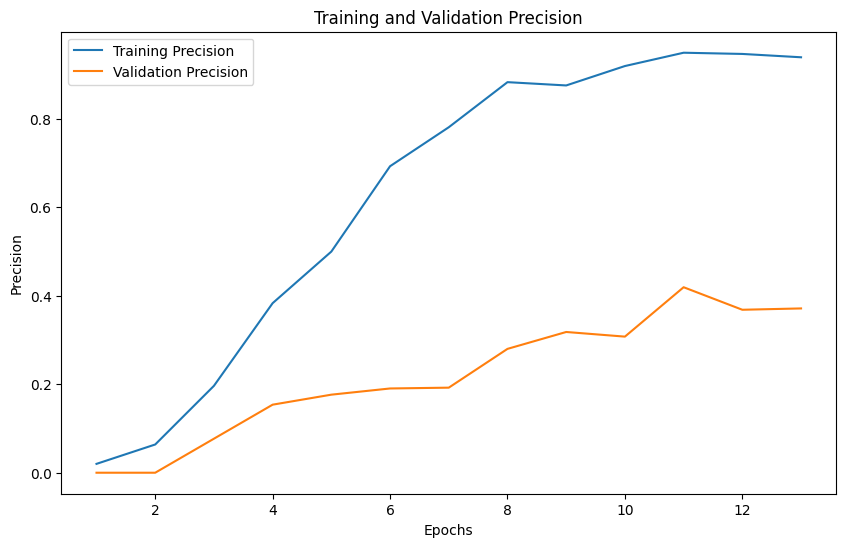

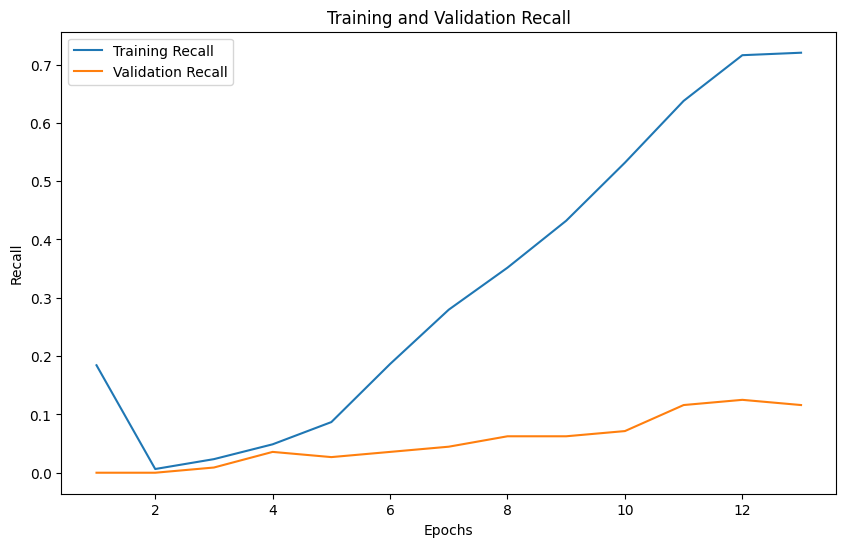

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    """
    Plots available training and validation metrics from the history object.
    """
    epochs = range(1, len(history.history['loss']) + 1)
    # Plot Accuracy
    if 'accuracy' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
        plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    # Plot Loss
    if 'loss' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['loss'], label='Training Loss')
        plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    # Plot Precision
    precision_key = next((key for key in history.history.keys() if 'precision' in key), None)
    if precision_key:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history[precision_key], label='Training Precision')
        plt.plot(epochs, history.history[f'val_{precision_key}'], label='Validation Precision')
        plt.title('Training and Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

    # Plot Recall
    recall_key = next((key for key in history.history.keys() if 'recall' in key), None)
    if recall_key:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history[recall_key], label='Training Recall')
        plt.plot(epochs, history.history[f'val_{recall_key}'], label='Validation Recall')
        plt.title('Training and Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
        plt.show()

# Use the updated function
plot_metrics(history)
plot_metrics(history_fine)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Parameters
img_height, img_width = 224, 224  # Image dimensions

# Custom Weighted Binary Crossentropy Loss
def weighted_binary_crossentropy(pos_weight=50.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        loss = -(
            pos_weight * y_true * tf.math.log(y_pred) +
            (1 - y_true) * tf.math.log(1 - y_pred)
        )
        return tf.reduce_mean(loss)
    return loss

# Load Pre-Trained DenseNet Model
base_model = DenseNet121(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze base layers initially

# Add Custom Layers
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)  # Regularization
outputs = layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(0.01))(x)
model = Model(inputs, outputs)

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=weighted_binary_crossentropy(pos_weight=100.0),  # Strong emphasis on minority class
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the Model (with frozen base layers)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

# Unfreeze Base Layers for Fine-Tuning
base_model.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=weighted_binary_crossentropy(pos_weight=100.0),  # Adjust if needed
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Fine-Tune the Model
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate on Test Dataset
test_results = model.evaluate(test_dataset)
print(f"Test Results - Loss: {test_results[0]:.4f}, Accuracy: {test_results[1]:.4f}, "
      f"Precision: {test_results[2]:.4f}, Recall: {test_results[3]:.4f}")

# Predict on Test Dataset
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.2).astype(int)  # Lower threshold to 0.2

# Extract True Labels
true_labels = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)

# Compute Additional Metrics
precision = precision_score(true_labels, predicted_labels, zero_division=0)
recall = recall_score(true_labels, predicted_labels, zero_division=0)
f1 = f1_score(true_labels, predicted_labels, zero_division=0)

print(f"Final Test Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
829/829 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.4107 - loss: 2.0521 - precision_3: 0.0216 - recall_3: 0.6798 - val_accuracy: 0.2486 - val_loss: 1.6086 - val_precision_3: 0.0205 - val_recall_3: 0.9286 - learning_rate: 1.0000e-04
Epoch 2/20
829/829 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.3541 - loss: 1.8724 - precision_3: 0.0224 - recall_3: 0.7847 - val_accuracy: 0.3624 - val_loss: 1.5258 - val_precision_3: 0.0234 - val_recall_3: 0.9018 - learning_rate: 1.0000e-04
Epoch 3/20
829/829 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.4231 - loss: 1.7203 - precision_3: 0.0247 - recall_3: 0.8013 - val_accuracy: 0.4815 - val_loss: 1.4752 - val_precision_3: 0.0270 - val_recall_3: 0.8482 - learning_rate: 1.0000e-04
Epoch 4/20
829/829 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.4865 - loss: 1.6111 - precision_3: 0.0263 - recall_3: 0.8072 - val_accuracy: 0.5435 - val_loss: 1.4437 - val_precision_3: 0.0306 - val_re

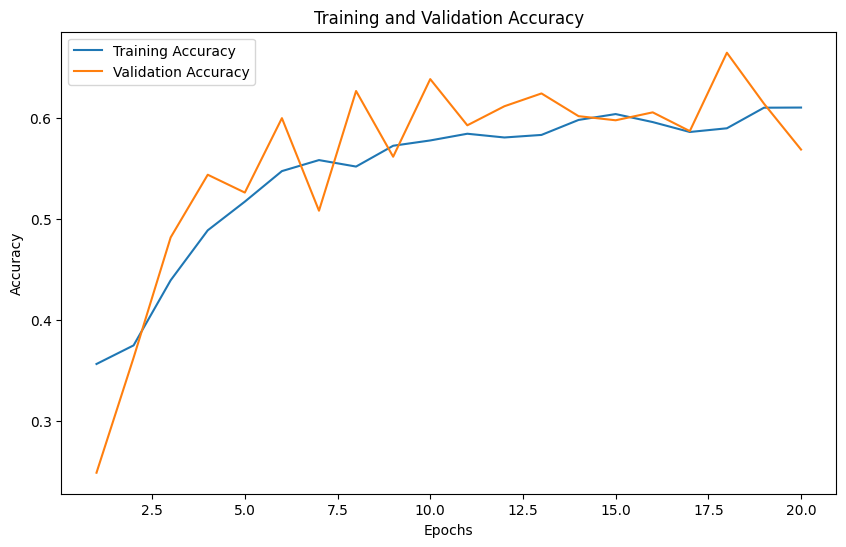

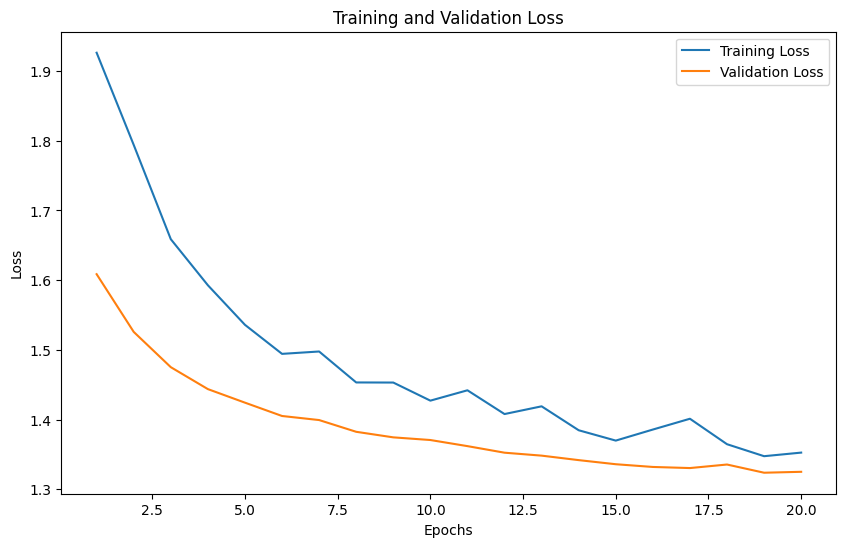

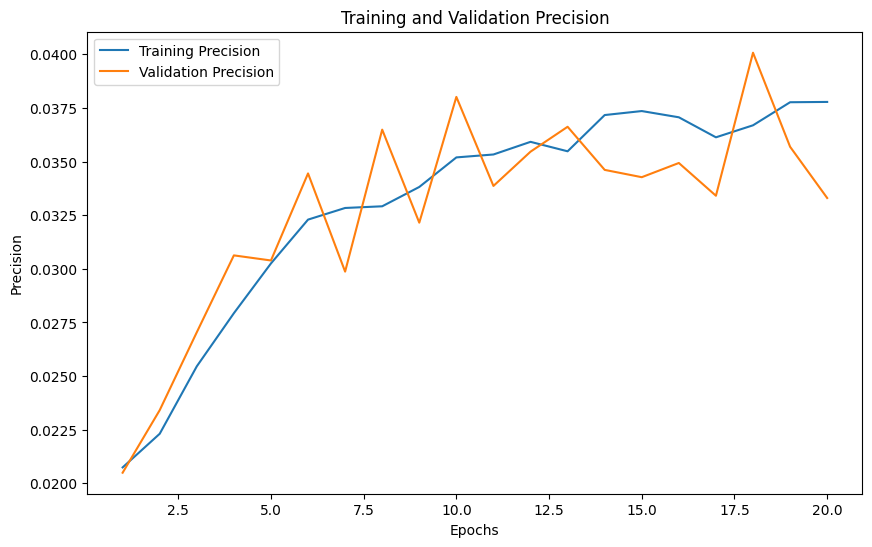

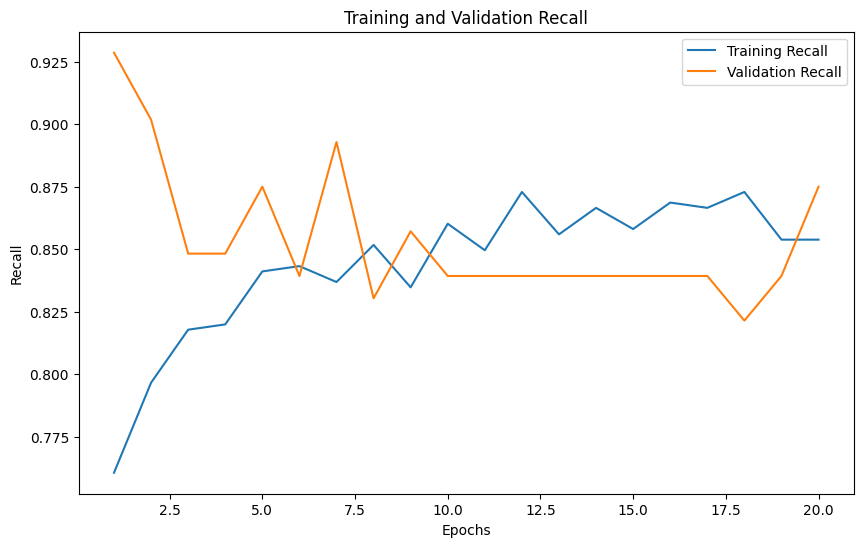

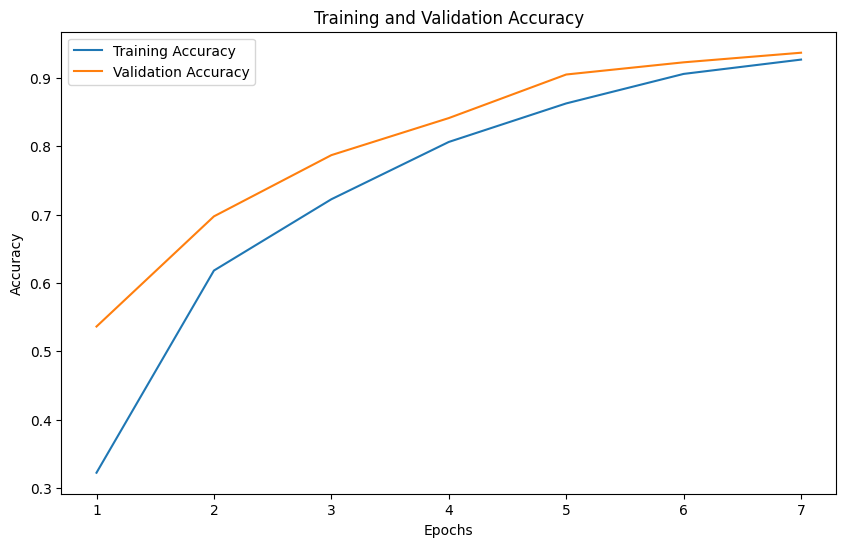

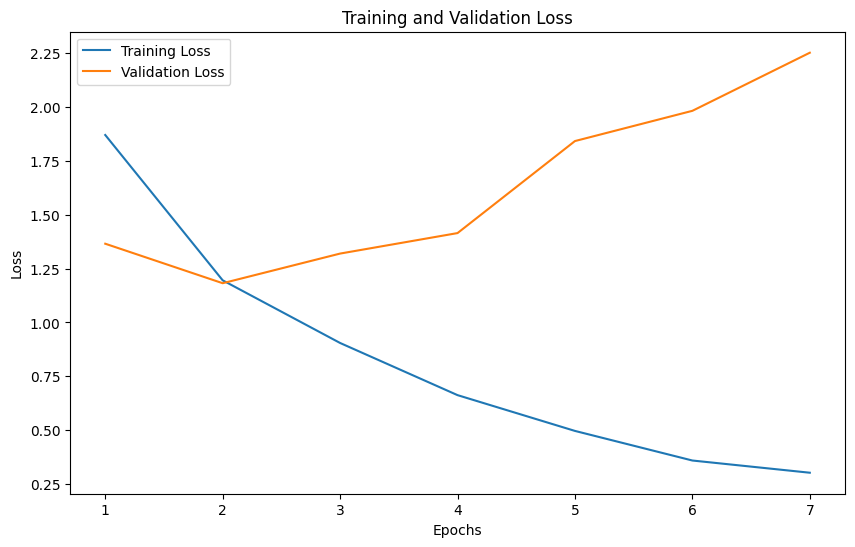

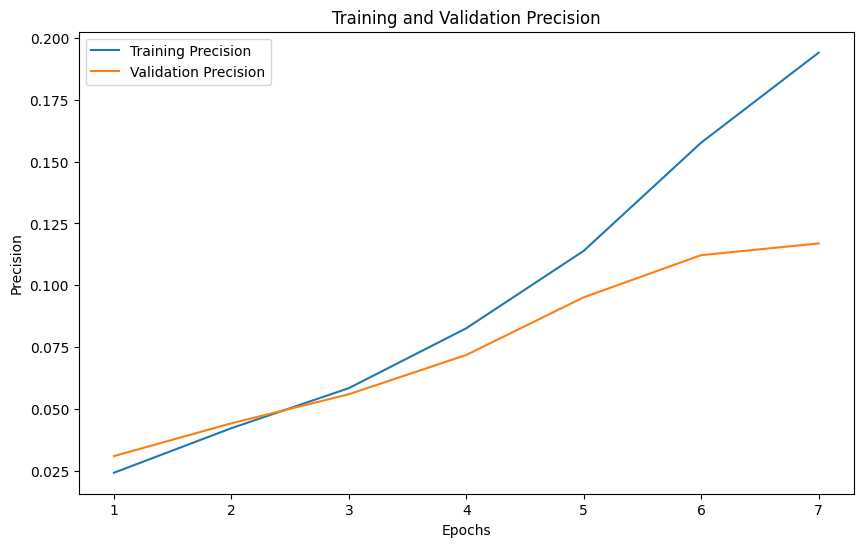

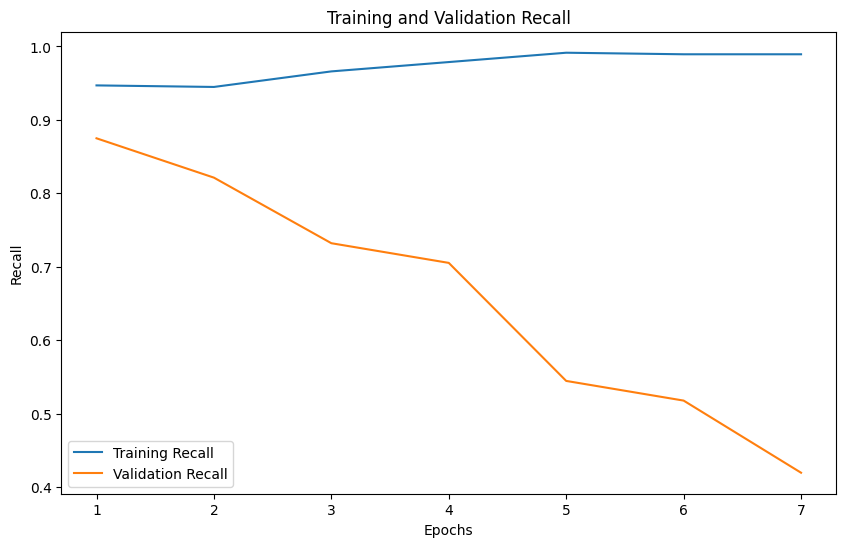

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    """
    Plots available training and validation metrics from the history object.
    """
    epochs = range(1, len(history.history['loss']) + 1)
    # Plot Accuracy
    if 'accuracy' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
        plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    # Plot Loss
    if 'loss' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['loss'], label='Training Loss')
        plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    # Plot Precision
    precision_key = next((key for key in history.history.keys() if 'precision' in key), None)
    if precision_key:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history[precision_key], label='Training Precision')
        plt.plot(epochs, history.history[f'val_{precision_key}'], label='Validation Precision')
        plt.title('Training and Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

    # Plot Recall
    recall_key = next((key for key in history.history.keys() if 'recall' in key), None)
    if recall_key:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history[recall_key], label='Training Recall')
        plt.plot(epochs, history.history[f'val_{recall_key}'], label='Validation Recall')
        plt.title('Training and Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
        plt.show()

# Plot metrics for the DenseNet121 training
plot_metrics(history)

# Plot metrics for the fine-tuning phase
plot_metrics(history_fine)

In [8]:
import tensorflow as tf
import numpy as np

# Parameters
img_height, img_width = 224, 224  # Image dimensions
batch_size = 32  # Batch size

# Assuming `train_data` is already loaded with columns `image_path` and `target`
# Identify minority and majority classes
minority_class = train_data['target'].value_counts().idxmin()
majority_class = train_data['target'].value_counts().idxmax()

minority_data = train_data[train_data['target'] == minority_class]
majority_data = train_data[train_data['target'] == majority_class]

# Downsample majority class to 30%
majority_sample_size = int(0.3 * len(majority_data))
majority_sampled = majority_data.sample(n=majority_sample_size, random_state=42)

# Upsample minority class to 10% of total majority class size
desired_minority_size = int(0.1 * len(majority_sampled))
num_augmentations = (desired_minority_size - len(minority_data)) // len(minority_data) + 1

# Simple augmentation function for minority class
def simple_augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image

# Augment minority data
augmented_images, augmented_labels = [], []
for image_path, label in zip(minority_data['image_path'].values, minority_data['target'].values):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img = img / 255.0  # Normalize
    augmented_images.append(img.numpy())  # Add original image
    augmented_labels.append(label)
    for _ in range(num_augmentations):  # Generate multiple augmented samples
        augmented_img = simple_augment_image(img)
        augmented_images.append(augmented_img.numpy())
        augmented_labels.append(label)

# Limit the augmented minority samples to desired size
augmented_images = np.array(augmented_images[:desired_minority_size])
augmented_labels = np.array(augmented_labels[:desired_minority_size])

# Load majority sampled data
majority_images, majority_labels = [], []
for image_path, label in zip(majority_sampled['image_path'].values, majority_sampled['target'].values):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img = img / 255.0  # Normalize
    majority_images.append(img.numpy())
    majority_labels.append(label)

majority_images = np.array(majority_images)
majority_labels = np.array(majority_labels)

# Combine augmented minority and downsampled majority class data
combined_images = np.concatenate([augmented_images, majority_images], axis=0)
combined_labels = np.concatenate([augmented_labels, majority_labels], axis=0)

# Shuffle and create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((combined_images, combined_labels))
dataset = dataset.shuffle(buffer_size=len(combined_labels))

# Train-Validation Split
train_size = int(0.8 * len(combined_labels))
train_dataset = dataset.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define a Simple CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train the Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=train_size // batch_size,
    validation_steps=(len(combined_labels) - train_size) // batch_size,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

# Evaluate the Model
test_results = model.evaluate(val_dataset, steps=(len(combined_labels) - train_size) // batch_size)
print(f"Test Results - Loss: {test_results[0]:.4f}, Accuracy: {test_results[1]:.4f}, "
      f"Precision: {test_results[2]:.4f}, Recall: {test_results[3]:.4f}")


Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.8941 - loss: 0.3632 - precision: 0.2066 - recall: 0.0473 - val_accuracy: 0.9062 - val_loss: 0.2828 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
  1/214 ━━━━━━━━━━━━━━━━━━━━ 9:58 3s/step - accuracy: 0.9091 - loss: 0.2361 - precision: 0.0000e+00 - recall: 0.0000e+00

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9091 - loss: 0.2361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9091 - val_loss: 0.2668 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9128 - loss: 0.2725 - precision: 0.0326 - recall: 5.3191e-05 - val_accuracy: 0.9086 - val_loss: 0.2552 - val_precision: 1.0000 - val_recall: 0.0064 - learning_rate: 1.0000e-04
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - accuracy: 0.9545 - loss: 0.2081 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9545 - val_loss: 0.1894 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9102 - loss: 0.2533 - precision: 0.7156 - recall: 0.0160 - val_accuracy: 0.9039 - val_loss: 0.2524 - val_precision: 0.5714 - val_recall: 0.0244 - learning_rate: 1.0000e-04
Epoch 6/10
214/214 

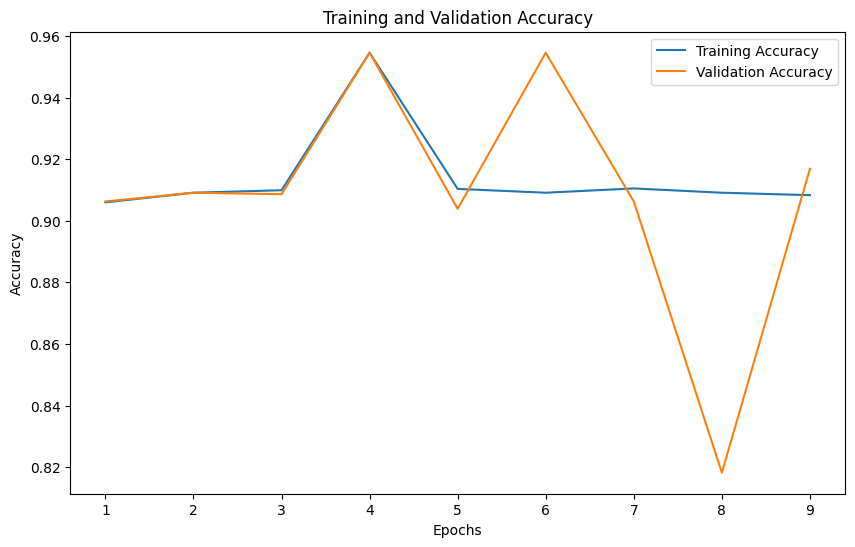

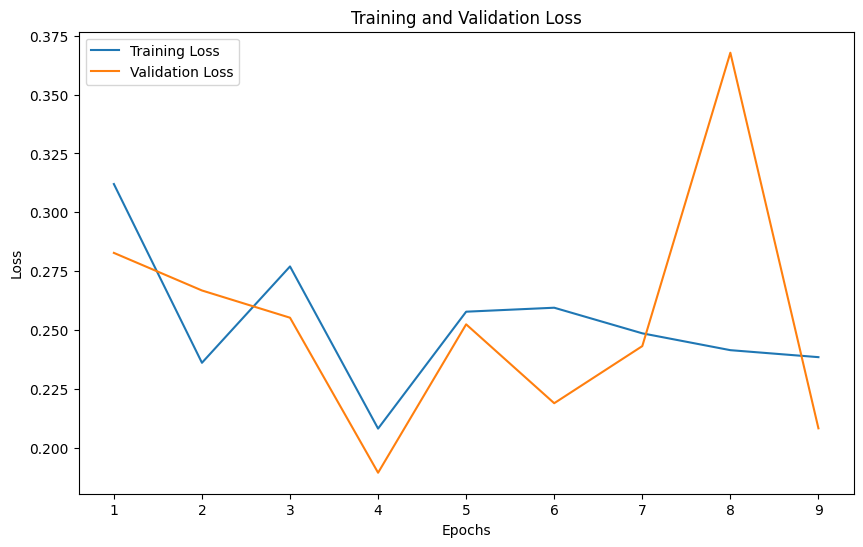

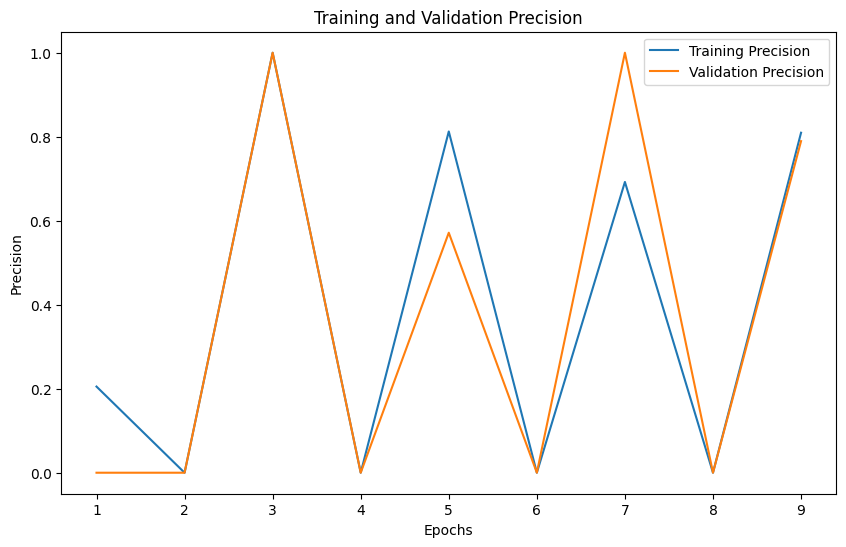

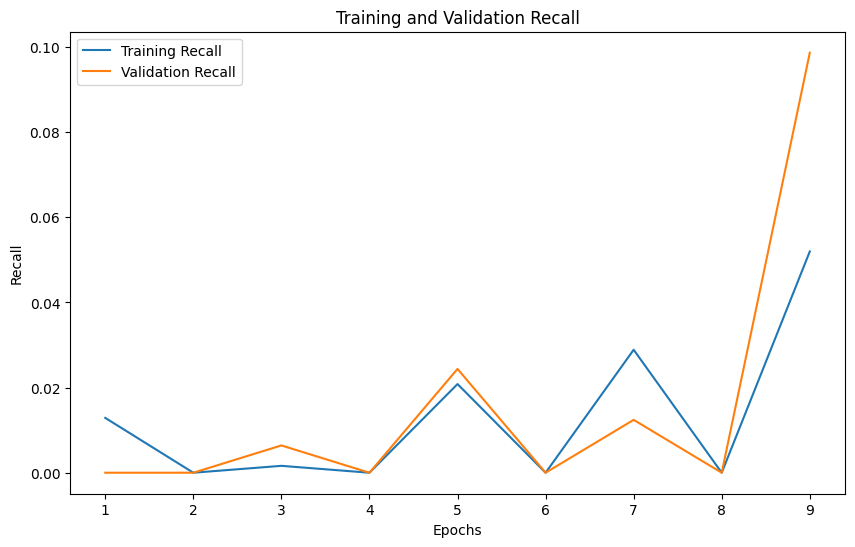

NameError: name 'history_fine' is not defined

In [9]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    """
    Plots available training and validation metrics from the history object.
    """
    epochs = range(1, len(history.history['loss']) + 1)
    # Plot Accuracy
    if 'accuracy' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
        plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    # Plot Loss
    if 'loss' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['loss'], label='Training Loss')
        plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    # Plot Precision
    precision_key = next((key for key in history.history.keys() if 'precision' in key), None)
    if precision_key:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history[precision_key], label='Training Precision')
        plt.plot(epochs, history.history[f'val_{precision_key}'], label='Validation Precision')
        plt.title('Training and Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

    # Plot Recall
    recall_key = next((key for key in history.history.keys() if 'recall' in key), None)
    if recall_key:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history[recall_key], label='Training Recall')
        plt.plot(epochs, history.history[f'val_{recall_key}'], label='Validation Recall')
        plt.title('Training and Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
        plt.show()

# Plot metrics for the DenseNet121 training
plot_metrics(history)

# Plot metrics for the fine-tuning phase
plot_metrics(history_fine)